In [8]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.table import Table, vstack, hstack, unique,join
import matplotlib.pyplot as plt
import pandas as pd
import sys

# sys.path.append("/global/u2/b/bid13/VI/prospect/py")

import desispec.coaddition
import desispec.io
import desispec.spectra
# from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.sv1.sv1_targetmask import desi_mask
from prospect import utilities,plotframes, myspecselect, myspecupdate
from desispec.coaddition import coadd_cameras
from prospect import utilities ,plotframes
# from prospect_my import plotframes

from stack_spectra import _common_grid

In [120]:
my_path = Path("/global/cscratch1/sd/bid13/stack-spectra")

In [121]:
spec = desispec.io.read_spectra(my_path /  "spectra_coadd_cam.fits")
zcat = Table.read(my_path / "zcat.fits")
flux = spec.flux['brz']
wl = spec.wave['brz']
ivar = spec.ivar['brz']

INFO:spectra.py:253:read_spectra: iotime 0.485 sec to read spectra_coadd_cam.fits at 2021-04-04T17:39:05.070590


In [122]:
print(len(flux[0]),len(ivar[0]))

7781 7781


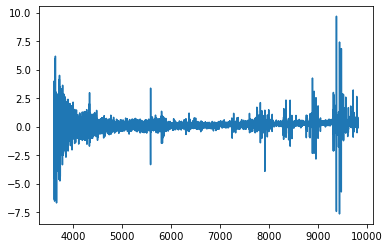

In [123]:
plt.plot(wl,flux[1])

In [124]:
def normalize(flux,ivar):
    norm = np.nanmedian(flux,axis=1).reshape(315,1)
    flux = flux/norm
    ivar = ivar*norm**2
    
    return ivar, flux

In [125]:
i,f = normalize(flux,ivar)

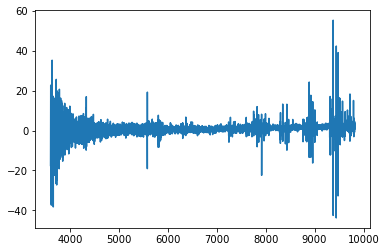

In [126]:
plt.plot(wl,f[1])

In [127]:
new_f,new_i,new_wl = _common_grid(f, wl, i, zcat['Z'], z_out=0.0, wave_grid=None)

In [182]:
def wavg(flux,ivar):
    num = np.sum(flux*ivar,axis=0)
    denom = np.sum(ivar,axis=0)
    avg = num/denom
    
    return(avg)

In [183]:
wavg_f = wavg(new_f,new_i)

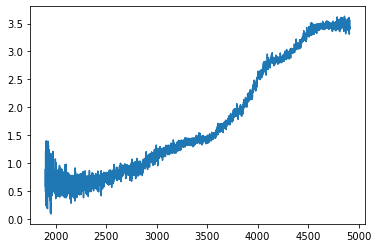

In [184]:
plt.plot(new_wl,wavg_f)

array([ -3.424125  , -19.03993669,  14.11282993, ...,   0.4740582 ,
         3.58030053,   0.28661597])